In [1]:
%matplotlib inline

import pandas as pd
import nivapy3 as nivapy
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np
import lmfit
import statsmodels.formula.api as smf
import warnings

warnings.simplefilter("ignore")
plt.style.use("ggplot")

# Compare DON and DOP to DOC

We are interested in power-law relationships between (DON & DOC) and (DOP & DOC) - see e-mail from Phil received 07.11.2019 at 10.39. For our rivers of interest, Denmark has very little DOC data and Sweden does not report sub-divisions of organic N or P. Because of this, my estimated daily DON and DOP concentrations for Sweden and Denmark are already underpinned by regressions based on Norwegian data (see [here](https://nbviewer.jupyter.org/github/JamesSample/martini/blob/master/notebooks/02_riverine_inputs.ipynb) for details).

In terms of exploring relationships in the "raw"/primary data, it therefore makes sense to **focus on Norway**, which has more detailed monitoring for the Skagerrak rivers.

In [2]:
def long_to_wide(df, par_list):
    """ Convenience function for subsetting parameters and converting
        from 'long' to 'wide' format.
    """
    df2 = df.copy()

    # Get pars of interest
    df2 = df2.query("par_unit in @par_list")

    # Restructure
    df2.set_index(["station_id", "sample_date", "par_unit"], inplace=True)
    df2 = df2.unstack("par_unit")
    df2.columns = [i[1] for i in df2.columns.to_flat_index()]
    df2.reset_index(inplace=True)

    return df2

## 1. Norway

### 1.1. DON

`DON` is not reported directly, but a few Norwegian stations record `PON`. The workflow is as follows:

 1. Rename `N-NO3` as `N-SNOX` and average duplicates (because nitrite is negligible; see [here](https://nbviewer.jupyter.org/github/JamesSample/martini/blob/master/notebooks/02_riverine_inputs.ipynb#1.1.-Ignoring-nitrite-in-Norway) for justification)
 
 2. Calculate `TON` as (`N-TOT` - `N-SNOX` - `N-NH4`)
 
 3. Calculate `DON` as (`TON` - `PON`)
 
 4. Compare `DON` to  `DOC`

There are 52 samples from 8 Norwegian stations with contemporaneous DON and DOC data.



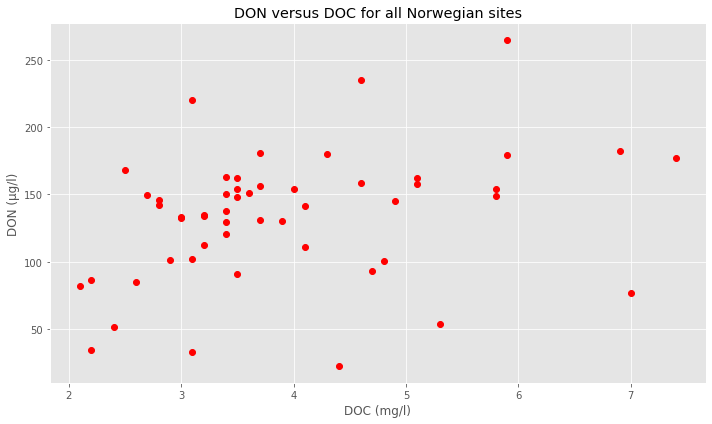

In [3]:
# Read Norway data
csv_path = r"../data/tidy/martini_norway_chem_tidy.csv"
wc_df = pd.read_csv(csv_path, encoding="utf-8")
wc_df.drop(["station_name", "lon", "lat"], axis=1, inplace=True)

# Reclass N-NO3 to N-SNOX in Norway
wc_df["par_unit"].replace({"N-NO3_µg/l": "N-SNOX_µg/l"}, inplace=True)

# Average duplicates
wc_df = wc_df.groupby(["station_id", "sample_date", "par_unit"]).mean().reset_index()

# Restructure
par_list = ["N-TOT_µg/l", "N-SNOX_µg/l", "N-NH4_µg/l", "PON_µg/l", "DOC_mg/l"]
wc_df = long_to_wide(wc_df, par_list)
wc_df.dropna(how="any", inplace=True)

# Calculate TON and DON
wc_df["TON_µg/l"] = wc_df["N-TOT_µg/l"] - wc_df["N-SNOX_µg/l"] - wc_df["N-NH4_µg/l"]
wc_df["DON_µg/l"] = wc_df["TON_µg/l"] - wc_df["PON_µg/l"]

print(
    f"There are {len(wc_df)} samples from {len(wc_df.station_id.unique())} Norwegian stations "
    "with contemporaneous DON and DOC data.\n"
)

# Plot all data
fig = plt.figure(figsize=(10, 6))
plt.plot(wc_df["DOC_mg/l"], wc_df["DON_µg/l"], "ro")
plt.xlabel("DOC (mg/l)")
plt.ylabel("DON (µg/l)")
plt.title("DON versus DOC for all Norwegian sites")
plt.tight_layout()

There is no clear relationship in the dataset as a whole. Perhaps a weak linear trend (?), but certainly not an obvious power-law. What about considering each site separately?

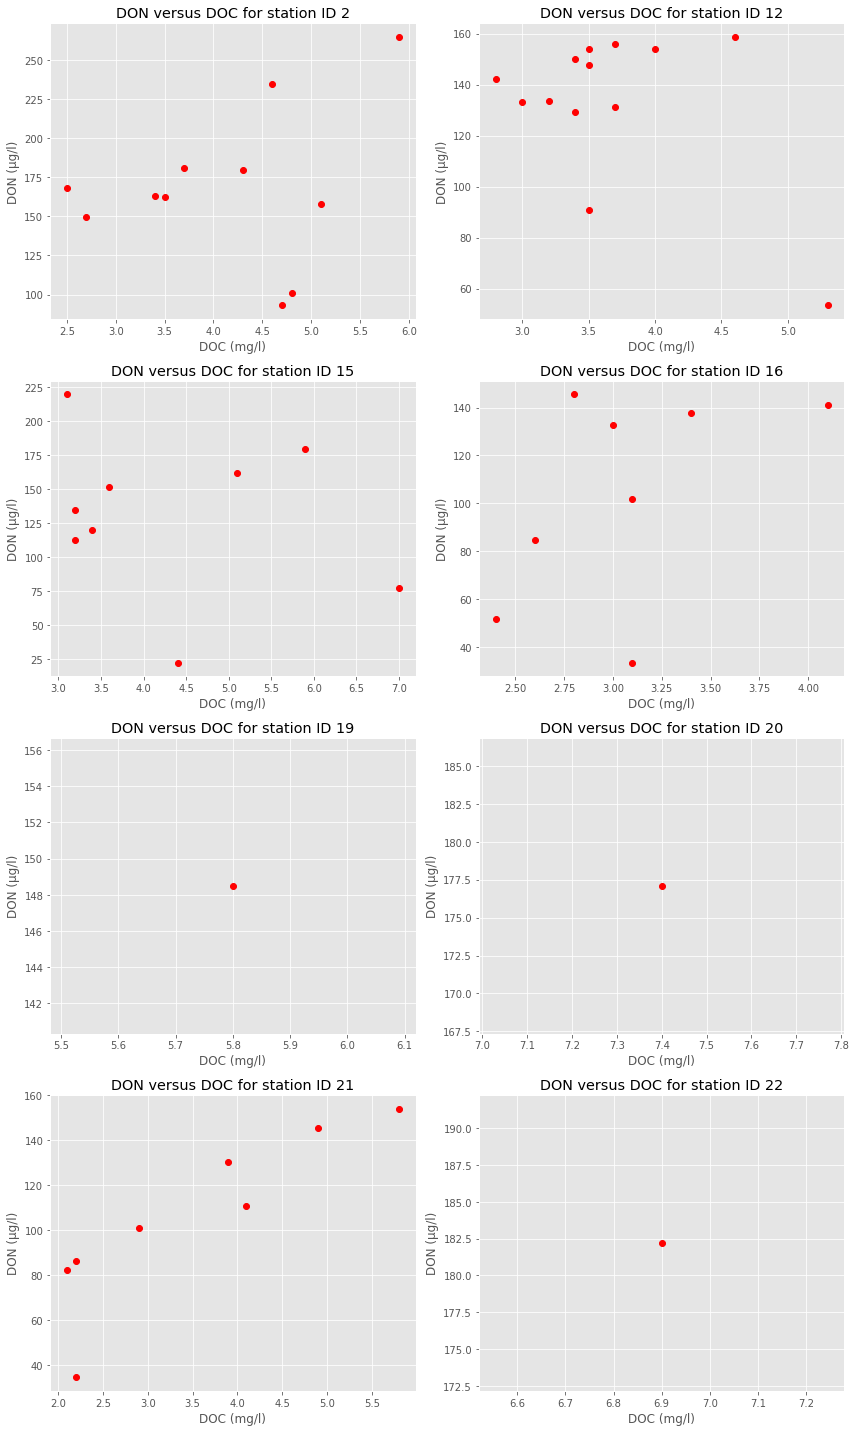

In [4]:
# Subplot for each site
fix, axes = plt.subplots(nrows=4, ncols=2, figsize=(12, 20))
axes = axes.flatten()

for idx, stn_id in enumerate(wc_df.station_id.unique()):
    df = wc_df.query("station_id == @stn_id")

    axes[idx].plot(df["DOC_mg/l"], df["DON_µg/l"], "ro")
    axes[idx].set_xlabel("DOC (mg/l)")
    axes[idx].set_ylabel("DON (µg/l)")
    axes[idx].set_title(f"DON versus DOC for station ID {stn_id}")

plt.tight_layout()

There are no clear patterns here either, except at station ID 21 (**Otra ved Skråstad**), which shows evidence of a positive linear relationship. We do not have enough data to fit separate regressions for each site, so from a practical perspective we need to use the combined dataset. The code below fits a power-law (motivated by domain knowledge), even though it looks as though it will perform badly.

In [5]:
# Get cols of interest
df = wc_df[["DON_µg/l", "DOC_mg/l"]]

# Log-transform
df2 = np.log10(df)

# Linear regression
res = smf.ols(formula='Q("DON_µg/l") ~ Q("DOC_mg/l")', data=df2).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:          Q("DON_µg/l")   R-squared:                       0.079
Model:                            OLS   Adj. R-squared:                  0.060
Method:                 Least Squares   F-statistic:                     4.269
Date:                Wed, 20 May 2020   Prob (F-statistic):             0.0440
Time:                        07:54:19   Log-Likelihood:                 10.450
No. Observations:                  52   AIC:                            -16.90
Df Residuals:                      50   BIC:                            -13.00
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         1.8346      0.125     14.619

The model is significant at $p < 0.05$, but the variance explained is low (8%). For a power-law of the form

$$y = ax^b$$

the best estimate for $b$ from the regression above is **0.44**, while the best estimate for $a$, including correction for **back-transformation bias**, is:

$$10^{intercept}*e^{2.615s^2}$$

where 

$$s^2 = \frac{1}{N} \sum_i e_i^2$$

(see [here](https://nbviewer.jupyter.org/github/JamesSample/martini/blob/master/notebooks/process_norway_chem.ipynb#3.-Concentration-discharge-relationships) for details).

DON = a*(DOC)^b
Best estimate for a: 75.81
Best estimate for b: 0.44


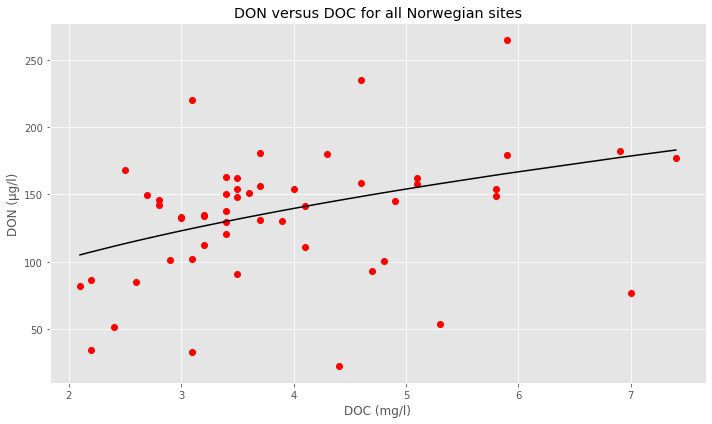

In [6]:
# Print param estimates
a_est = (10 ** res.params[0]) * np.exp(2.651 * ((res.resid.values) ** 2).mean())
b_est = res.params[1]

print("DON = a*(DOC)^b")
print(f"Best estimate for a: {a_est:.2f}")
print(f"Best estimate for b: {b_est:.2f}")

# Get fitted curve
x = df["DOC_mg/l"].sort_values()
y = a_est * x ** b_est

# Plot
fig = plt.figure(figsize=(10, 6))
plt.plot(df["DOC_mg/l"], df["DON_µg/l"], "ro")
plt.plot(x, y, "k-")
plt.xlabel("DOC (mg/l)")
plt.ylabel("DON (µg/l)")
plt.title("DON versus DOC for all Norwegian sites")
plt.tight_layout()

### 1.2. DOP

We don't have any measurements subdividing organic P. In the notebook [here](https://nbviewer.jupyter.org/github/JamesSample/martini/blob/master/notebooks/02_riverine_inputs.ipynb#1.4.-Compare-TDP-and-P-TOT-in-Denmark-and-Norway), I made the (fairly dodgy) assumption that the ratio of `DOP:TOP` will be the same as `TDP:P-TOT`, which is **0.2924**. I'll make the same assumption here to estimate `DOP`. 

There are 223 samples from 12 Norwegian stations with contemporaneous DOP and DOC data.



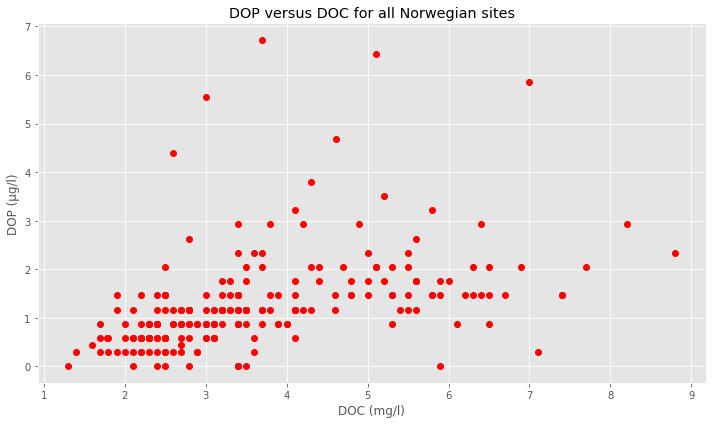

In [7]:
# Read Norway data
csv_path = r"../data/tidy/martini_norway_chem_tidy.csv"
wc_df = pd.read_csv(csv_path, encoding="utf-8")
wc_df.drop(["station_name", "lon", "lat"], axis=1, inplace=True)

# Restructure
par_list = ["P-TOT_µg/l", "TIP_µg/l", "DOC_mg/l"]
wc_df = long_to_wide(wc_df, par_list)
wc_df.dropna(how="any", inplace=True)

# Calculate
wc_df["TOP_µg/l"] = wc_df["P-TOT_µg/l"] - wc_df["TIP_µg/l"]
wc_df["TOP_µg/l"][wc_df["TOP_µg/l"] < 0] = 0
wc_df["DOP_µg/l"] = 0.2924 * wc_df["TOP_µg/l"]

print(
    f"There are {len(wc_df)} samples from {len(wc_df.station_id.unique())} Norwegian stations "
    "with contemporaneous DOP and DOC data.\n"
)

# Plot all data
fig = plt.figure(figsize=(10, 6))
plt.plot(wc_df["DOC_mg/l"], wc_df["DOP_µg/l"], "ro")
plt.xlabel("DOC (mg/l)")
plt.ylabel("DOP (µg/l)")
plt.title("DOP versus DOC for all Norwegian sites")
plt.tight_layout()

Again, there is no clear power-law relationship here, although the suggestion of a weak positive correlation is perhaps slightly better than for `DON`. We can choose to fit a power-law based on domain knowledge, as shown below.

In [8]:
# Get cols of interest
df = wc_df[["DOP_µg/l", "DOC_mg/l"]]

# Remove DOP = 0 so can log-transform
df2 = df[df["DOP_µg/l"] > 0]

# Log-transform
df2 = np.log10(df2)

# Linear regression
res = smf.ols(formula='Q("DOP_µg/l") ~ Q("DOC_mg/l")', data=df2).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:          Q("DOP_µg/l")   R-squared:                       0.347
Model:                            OLS   Adj. R-squared:                  0.344
Method:                 Least Squares   F-statistic:                     111.9
Date:                Wed, 20 May 2020   Prob (F-statistic):           2.91e-21
Time:                        07:54:20   Log-Likelihood:                 11.899
No. Observations:                 213   AIC:                            -19.80
Df Residuals:                     211   BIC:                            -13.08
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -0.5035      0.053     -9.413

This regression is better than for `DON`: the relationship is highly significant and the amount variance explained is 35% (which is still low, but better than above). The code below performs back-transformation of the parameters.

DOP = a*(DOC)^b
Best estimate for a: 0.36
Best estimate for b: 1.02


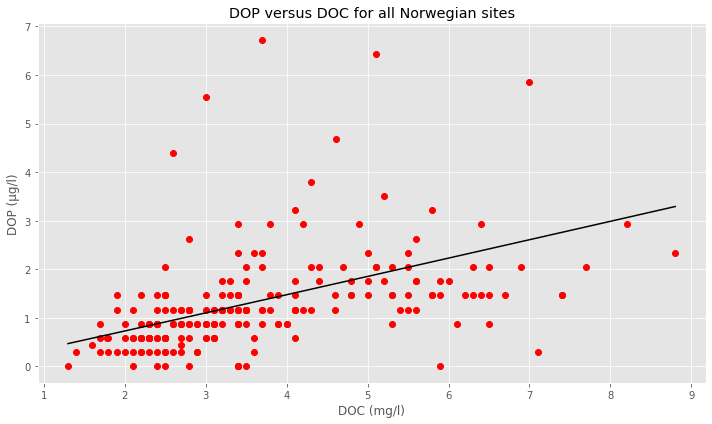

In [9]:
# Print param estimates
a_est = (10 ** res.params[0]) * np.exp(2.651 * ((res.resid.values) ** 2).mean())
b_est = res.params[1]

print("DOP = a*(DOC)^b")
print(f"Best estimate for a: {a_est:.2f}")
print(f"Best estimate for b: {b_est:.2f}")

# Get fitted curve
x = df["DOC_mg/l"].sort_values()
y = a_est * x ** b_est

# Plot
fig = plt.figure(figsize=(10, 6))
plt.plot(df["DOC_mg/l"], df["DOP_µg/l"], "ro")
plt.plot(x, y, "k-")
plt.xlabel("DOC (mg/l)")
plt.ylabel("DOP (µg/l)")
plt.title("DOP versus DOC for all Norwegian sites")
plt.tight_layout()

## 2. Summary

Attempting to fit power-laws to the Norwegian data yields the following relationships:

 * $DON = 75.81*DOC^{0.44}$. A **poor relationship** ($R^2 \approx 8\%$). Probably not worth using
 
 * $DOP = 0.36*DOC^{1.02}$. A **moderate relationship** ($R^2 \approx 35\%$). Essentially linear